<a href="https://colab.research.google.com/github/Ashish110411/Personal_Finance_Prediction/blob/main/Personal_Finance_Management_and_Wealth_Prediction_using_Machine_Learning_for_Indian_Households.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indian Household Wealth Predictor

## Project Overview

This project aims to build a machine learning-based system that can classify and predict the long-term wealth of Indian households. By analyzing income, expenditures, and lifestyle behavior, the model attempts to forecast projected wealth by the age of 60 and classify whether an individual is likely to become wealthy.

The solution involves both classification and regression approaches. Classification models predict whether a person will be considered "wealthy" or not, while regression models estimate the actual projected wealth in Indian Rupees. The ultimate goal is to provide personalized financial insights that prioritize healthy savings behavior over income alone.

We make use of several popular machine learning models such as Logistic Regression, Random Forest, XGBoost, and Multi-Layer Perceptron (MLP), and evaluate them using relevant metrics and visualizations.


## Uploading the Dataset

We begin by uploading our dataset to the Colab environment using the built-in `files.upload()` function. This allows us to manually upload CSV or Excel files from our local system into the notebook for further processing.

> **Note:** After running the code cell below, a file dialog will appear to select the dataset file.


In [247]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


## Loading and Inspecting the Dataset

Once the dataset is uploaded, we read it into a pandas DataFrame using `pd.read_csv()`. This provides a structured tabular format to analyze and manipulate the data. Displaying the first few rows using `df.head()` helps us understand the initial structure, columns, and a snapshot of the values contained in the dataset.


In [248]:
import pandas as pd
file_path = "data.csv"
df = pd.read_csv(file_path)
df.head()

,Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Groceries,Transport,...,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous
0,44637.249636,49,0,Self_Employed,Tier_1,13391.174891,0.000000,2206.490129,6658.768341,2636.970696,...,6200.537192,11265.627707,1685.696222,328.895281,465.769172,195.151320,678.292859,67.682471,0.000000,85.735517
1,26858.596592,34,2,Retired,Tier_2,5371.719318,0.000000,869.522617,2818.444460,1543.018778,...,1923.176434,9676.818733,540.306561,119.347139,141.866089,234.131168,286.668408,6.603212,56.306874,97.388606
2,50367.605084,35,1,Student,Tier_3,7555.140763,4612.103386,2201.800050,6313.222081,3221.396403,...,7050.360422,13891.450624,1466.073984,473.549752,410.857129,459.965256,488.383423,7.290892,106.653597,138.542422
3,101455.600247,21,0,Self_Employed,Tier_3,15218.340037,6809.441427,4889.418087,14690.149363,7106.130005,...,16694.965136,31617.953615,1875.932770,762.020789,1241.017448,320.190594,1389.815033,193.502754,0.000000,296.041183
4,24875.283548,52,4,Professional,Tier_2,4975.056710,3112.609398,635.907170,3034.329665,1276.155163,...,1874.099434,6265.700532,788.953124,68.160766,61.712505,187.173750,194.117130,47.294591,67.388120,96.557076


In [249]:
import warnings
warnings.filterwarnings('ignore')


## Data Preprocessing

### Dropping Unnecessary Columns

To simplify the dataset and remove potential multicollinearity, we first dropped the columns containing potential savings estimates and the `Desired_Savings` column. These columns were either redundant or derived, and not suitable for model training. The filtered columns were identified by checking for the substring `'Potential_Savings'` and explicitly dropping `Desired_Savings`.


In [250]:
columns_to_drop = [col for col in df.columns if 'Potential_Savings' in col]
columns_to_drop.append('Desired_Savings')
df = df.drop(columns=columns_to_drop)

### Data Cleaning

To ensure a clean dataset for model training, we began by checking for missing values in the dataset. Upon identifying rows with missing data, we chose to drop them, assuming the proportion of such rows was small and wouldn't significantly affect model performance.

After cleaning, we verified the structure of the dataset to understand the available features for analysis and modeling.


In [251]:
df.isnull().sum()
df = df.dropna()
df.columns

Index(['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent',
       'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out',
       'Entertainment', 'Utilities', 'Healthcare', 'Education',
       'Miscellaneous', 'Desired_Savings_Percentage', 'Disposable_Income'],
      dtype='object')

### Feature Engineering

To better capture the financial behavior of individuals, several new features were engineered from the available expense and income data:

- **Total_Expenditure**: Sum of all monthly spending across different categories like rent, groceries, transport, healthcare, etc.
- **Monthly_Savings**: Calculated as the difference between `Income` and `Total_Expenditure`.
- **Savings_Rate**: The ratio of savings to income, indicating how much of one's income is being saved each month.
- **Years_Left**: Number of working years left, assuming retirement age is 60.
- **Projected_Wealth**: Estimated future wealth without compounding, calculated as monthly savings multiplied by 12 months and remaining working years.

These engineered features provide a more holistic view of financial planning and are essential in modeling long-term financial outcomes.


In [252]:
expense_cols = ['Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport',
                'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education', 'Miscellaneous']

df['Total_Expenditure'] = df[expense_cols].sum(axis=1)
df['Monthly_Savings'] = df['Income'] - df['Total_Expenditure']
df['Savings_Rate'] = df['Monthly_Savings'] / df['Income']
df['Years_Left'] = 60 - df['Age']
df['Projected_Wealth'] = df['Monthly_Savings'] * 12 * df['Years_Left']  # without compounding
df.columns

Index(['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent',
       'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out',
       'Entertainment', 'Utilities', 'Healthcare', 'Education',
       'Miscellaneous', 'Desired_Savings_Percentage', 'Disposable_Income',
       'Total_Expenditure', 'Monthly_Savings', 'Savings_Rate', 'Years_Left',
       'Projected_Wealth'],
      dtype='object')

### Encoding Categorical Features

The dataset contains categorical variables such as **Occupation** and **City_Tier**. Since machine learning models require numerical inputs, these categorical values were encoded using **Label Encoding**.

- **Label Encoding** assigns a unique numeric value to each category in the column.
- This is suitable here because the categories are non-ordinal and are used only for identification, not ranking.

The following transformations were applied:
- `Occupation`: Encoded into numeric labels.
- `City_Tier`: Encoded to capture different levels of urban development.


In [253]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Occupation'] = le.fit_transform(df['Occupation'])
df['City_Tier'] = le.fit_transform(df['City_Tier'])


### Feature Scaling

To ensure that all numerical features contribute equally to the machine learning models, we applied **Standardization** using `StandardScaler`.

#### Why Scaling?
- Machine learning algorithms like Logistic Regression, Neural Networks, and KNN are sensitive to the scale of input features.
- Standardization transforms the data such that it has a **mean of 0** and a **standard deviation of 1**.

#### Scaled Columns:
The following numerical columns were scaled:
- `Income`
- `Age`
- `Dependents`
- `Total_Expenditure`
- `Monthly_Savings`
- `Savings_Rate`
- `Desired_Savings_Percentage`
- `Disposable_Income`


In [254]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['Income', 'Age', 'Dependents', 'Total_Expenditure', 'Monthly_Savings',
            'Savings_Rate', 'Desired_Savings_Percentage', 'Disposable_Income']

df[num_cols] = scaler.fit_transform(df[num_cols])


### Target Variable Creation

To formulate a **binary classification problem**, we introduced a new target label: `Wealthy_By_60`.

#### Criteria:
- A person is considered **wealthy** if their `Projected_Wealth` at age 60 is **greater than or equal to ₹50,00,000**.
- This threshold can be tuned based on further economic rationale or policy.

```python
wealth_threshold = 50_00_000
df['Wealthy_By_60'] = (df['Projected_Wealth'] >= wealth_threshold).astype(int)


## Classification Modeling

With the binary label `Wealthy_By_60` in place, we now move forward to build classification models that can **predict whether a person will be financially wealthy by the age of 60**.

### Objective:
Use supervised machine learning algorithms to classify individuals based on their financial and behavioral attributes into:
- `1` → Wealthy by 60  
- `0` → Not Wealthy by 60


### Train-Test Split

To ensure a robust evaluation of our classification models, we perform an **80-20 train-test split** on the dataset.

- **Features Used**:  
  We selected financial and behavioral features that influence wealth accumulation. These include:
  - Income  
  - Occupation (encoded)  
  - City_Tier (encoded)  
  - Age  
  - Number of Dependents  
  - Total Expenditure  
  - Monthly Savings  
  - Savings Rate  
  - Desired Savings Percentage  
  - Disposable Income  

- **Target Variable**:  
  `Wealthy_By_60` – a binary label indicating whether an individual is projected to be financially wealthy by age 60.




In [256]:
from sklearn.model_selection import train_test_split
wealth_threshold = 50_00_000
df['Wealthy_By_60'] = (df['Projected_Wealth'] >= wealth_threshold).astype(int)
features = ['Income', 'Occupation', 'City_Tier', 'Age', 'Dependents',
            'Total_Expenditure', 'Monthly_Savings', 'Savings_Rate',
            'Desired_Savings_Percentage', 'Disposable_Income']

X = df[features]
y = df['Wealthy_By_60']  # Classification label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Random Forest Classifier

We begin our classification with a **Random Forest Classifier**, a powerful ensemble method that builds multiple decision trees and aggregates their results for improved accuracy and generalization.



In [257]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(X_train, y_train)

y_pred = model_rfc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9965
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3491
           1       1.00      0.97      0.99       509

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



### Logistic Regression - Baseline Model

Logistic Regression is used as a **baseline classifier** for our binary wealth prediction task. It is a linear model that predicts the probability of a binary outcome using a logistic function.


In [258]:
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(max_iter=1000, random_state=42)
model_logreg.fit(X_train, y_train)
y_pred = model_logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9635
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3491
           1       0.90      0.81      0.85       509

    accuracy                           0.96      4000
   macro avg       0.93      0.90      0.91      4000
weighted avg       0.96      0.96      0.96      4000



### XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful and scalable tree-based ensemble learning algorithm. It is known for its accuracy and performance on structured/tabular data.


In [259]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.99625
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3491
           1       0.99      0.98      0.99       509

    accuracy                           1.00      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



### MLP Classifier

The Multi-Layer Perceptron (MLP) is a type of feedforward artificial neural network that learns complex patterns using hidden layers. It works well with non-linear data but may require more tuning and time to train.


In [260]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
model_mlp.fit(X_train, y_train)
y_pred = model_mlp.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.99525
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3491
           1       0.98      0.99      0.98       509

    accuracy                           1.00      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



### Classification Model Results

To predict whether an individual would be **Wealthy by age 60**, we trained and evaluated four classification models: Logistic Regression, Random Forest Classifier, XGBoost Classifier, and Multi-layer Perceptron (MLP).

#### Evaluation Metrics Considered:
- **Accuracy**: Overall correctness of the model.
- **Precision**: How many predicted wealthy individuals were actually wealthy.
- **Recall**: How many actual wealthy individuals were correctly predicted.
- **F1-Score**: Harmonic mean of precision and recall.

---

#### 1. Logistic Regression

- **Accuracy**: 96.35%
- **Precision**: 0.90
- **Recall**: 0.81
- **F1-Score**: 0.85

**Observations**:
- Performed well as a baseline model.
- Struggled with recall for the minority class (wealthy individuals), resulting in under-identification.
- Good for quick, interpretable results but lacks flexibility with complex patterns.

---

#### 2. Random Forest Classifier

- **Accuracy**: 99.65%
- **Precision**: 1.00
- **Recall**: 0.97
- **F1-Score**: 0.99

**Observations**:
- Delivered near-perfect performance.
- Handled class imbalance well with minimal false negatives.
- Benefited from ensemble learning and random feature selection.

---

#### 3. XGBoost Classifier

- **Accuracy**: 99.62%
- **Precision**: 0.99
- **Recall**: 0.98
- **F1-Score**: 0.99

**Observations**:
- Almost matched Random Forest in performance.
- Slightly better in recall than RFC, making it more robust in detecting wealthy individuals.
- Leveraged gradient boosting to refine predictions iteratively.

---

#### 4. MLP Classifier (Neural Network)

- **Accuracy**: 99.52%
- **Precision**: 0.98
- **Recall**: 0.99
- **F1-Score**: 0.98

**Observations**:
- Strong performer with balanced precision and recall.
- Learned non-linear relationships between features effectively.
- Requires more tuning but performs competitively with ensemble models.

---

#### Summary Table

| Model                 | Accuracy | Precision | Recall | F1-Score |
|----------------------|----------|-----------|--------|----------|
| Logistic Regression  | 96.35%   | 0.90      | 0.81   | 0.85     |
| Random Forest        | 99.65%   | 1.00      | 0.97   | 0.99     |
| XGBoost              | 99.62%   | 0.99      | 0.98   | 0.99     |
| MLP Classifier       | 99.52%   | 0.98      | 0.99   | 0.98     |

**Conclusion**: Random Forest and XGBoost clearly outperformed the rest in all metrics, making them ideal choices for this classification task. Logistic Regression, while interpretable, underperformed due to limited flexibility with non-linear and complex interactions.


### Confusion Matrix Analysis

To better understand how each model is performing in terms of **true positives**, **false positives**, **true negatives**, and **false negatives**, we visualized their respective confusion matrices below:

#### Observations:

- **Logistic Regression**:
  - High number of true negatives.
  - Misses a noticeable portion of actual wealthy individuals (higher false negatives).

- **Random Forest Classifier**:
  - Excellent at distinguishing between classes.
  - Very few false negatives or false positives.

- **XGBoost Classifier**:
  - Comparable to Random Forest.
  - Slightly better balance between precision and recall.

- **MLP Neural Network**:
  - Very high true positive rate.
  - Competitive with ensemble methods in capturing wealthy individuals accurately.

These matrices confirm the numerical metrics shown earlier and offer insights into **where and how** each model makes classification errors.


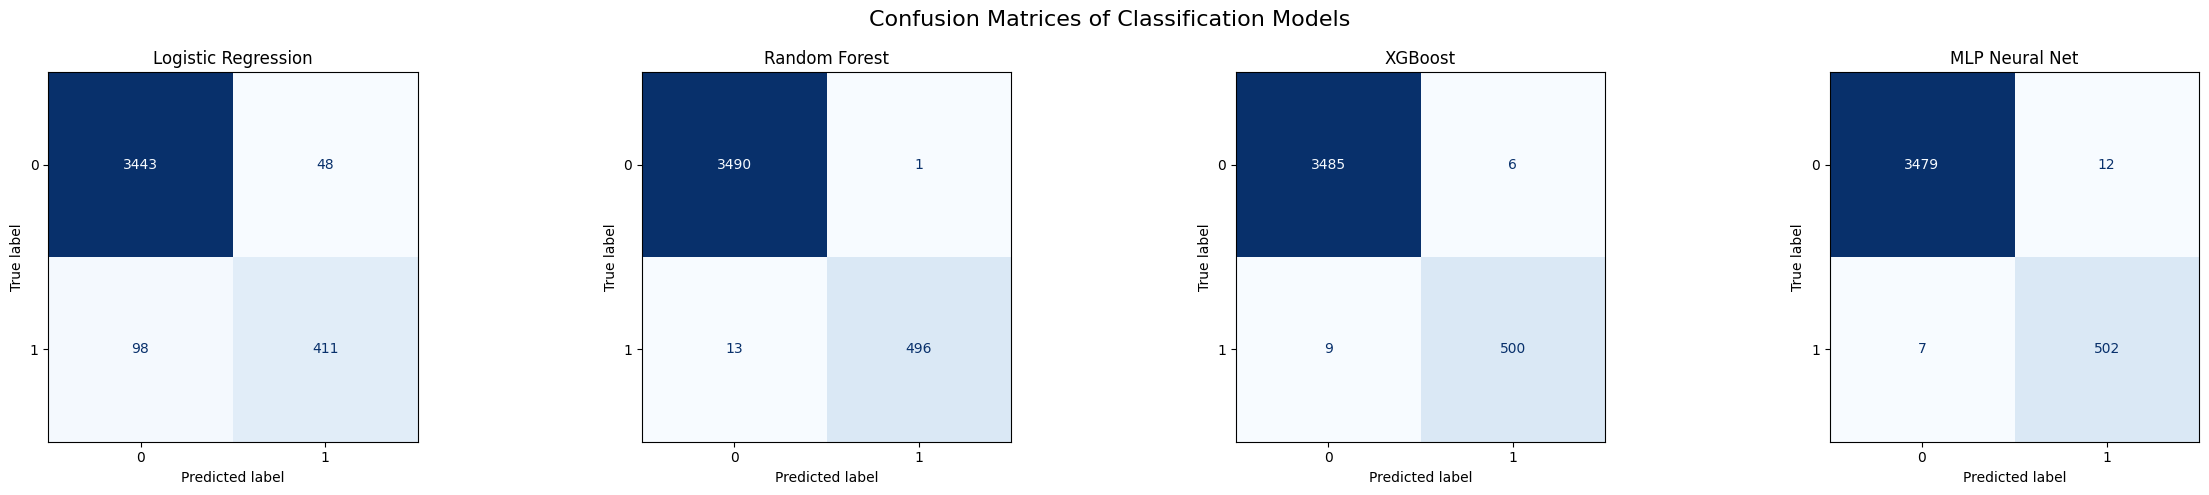

In [261]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_conf_matrices_1x4(models, model_names, X_test, y_test):
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # 1 row, 4 columns

    for ax, model, name in zip(axes, models, model_names):
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues', colorbar=False)
        ax.set_title(name)
        ax.grid(False)

    plt.suptitle("Confusion Matrices of Classification Models", fontsize=16)
    plt.tight_layout()
    plt.show()

# Prepare model list and names
model_list = [model_logreg, model_rfc, model_xgb, model_mlp]
model_names = ["Logistic Regression", "Random Forest", "XGBoost", "MLP Neural Net"]

# Plot
plot_conf_matrices_1x4(model_list, model_names, X_test, y_test)


## Regression Models: Projected Wealth Prediction

In this section, we shift our focus to regression models aimed at estimating an individual's projected wealth by the age of 60. The objective is to assess how well different models can predict this continuous variable based on a combination of financial and behavioral features.

We evaluate the following models:

1. **Linear Regression** – as a baseline.
2. **Random Forest Regressor** – to capture non-linear relationships.
3. **XGBoost Regressor** – a powerful gradient boosting-based model.

Each model's performance is assessed using standard regression metrics:

- **Mean Absolute Error (MAE)**
- **Root Mean Squared Error (RMSE)**
- **R² Score**

We also include plots such as:

- **Actual vs Predicted values** – to visually assess prediction quality.
- **Residual plots** – to examine model errors and check for patterns or biases.


### Data Splitting for Regression

To evaluate the performance of our regression models on unseen data, we split the dataset into training and testing sets using an 80:20 ratio. The feature set `X` remains the same as used in classification, while the target variable for regression is:

- **Projected_Wealth**: The estimated wealth a person will accumulate by the age of 60, based on their income, expenses, and savings behavior.

This setup ensures consistency across tasks and allows us to compare how well models generalize to new data.


In [262]:
from sklearn.model_selection import train_test_split
y_reg = df['Projected_Wealth']
X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42)


### Regression Model Training and Evaluation

To predict the long-term projected wealth of individuals, we trained and evaluated the following regression models:

- **Linear Regression**: A basic baseline model assuming a linear relationship between features and the target.
- **Random Forest Regressor**: An ensemble-based method capable of capturing non-linear patterns and feature interactions.
- **XGBoost Regressor**: A powerful gradient boosting algorithm known for its performance on structured data.

For each model, we calculated the following evaluation metrics on the test set:

- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors in predictions.
- **RMSE (Root Mean Squared Error)**: Penalizes large errors more than MAE and is useful for evaluating model stability.
- **R² Score**: Indicates how much variance in the target variable is explained by the model.

This multi-model evaluation helps us determine which regressor performs best in terms of accuracy and generalization for wealth prediction.


In [263]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

for name, model in regressors.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name}")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred))
    print("R² Score:", r2_score(y_test, y_pred))


Linear Regression
MAE: 1087468.3652571032
RMSE: 5345711425100.1
R² Score: 0.7451328864911262

Random Forest
MAE: 55645.444629457364
RMSE: 2659890576071.6533
R² Score: 0.8731845811598138

XGBoost
MAE: 101149.86766043605
RMSE: 4008189795066.028
R² Score: 0.8089018126441283


### Regression Results Summary

The performance of the three regression models on the test set is summarized below:

| Model              | MAE (₹)     | RMSE (₹)           | R² Score |
|-------------------|-------------|---------------------|----------|
| Linear Regression | 10,87,468   | 53,45,71,14,251.00  | 0.745    |
| Random Forest     | 55,645      | 26,59,89,05,760.71  | 0.873    |
| XGBoost           | 1,01,150    | 40,08,18,97,950.66  | 0.809    |

#### Key Observations:

- **Random Forest Regressor** achieved the best performance across all metrics, with the lowest MAE and highest R² score (~0.87), indicating excellent predictive accuracy and generalization.
- **XGBoost** also performed well, though slightly behind Random Forest in terms of error metrics and R².
- **Linear Regression**, while useful as a baseline, struggled to capture the non-linearity and complex interactions in the dataset. It had the highest error values and the lowest R² score (~0.74), suggesting it underfits the data.

These results highlight the importance of ensemble and boosting methods in handling structured financial data with interdependent variables.


### Saving the Best Regression Model

Since the **Random Forest Regressor** yielded the highest performance across evaluation metrics (lowest MAE and RMSE, highest R² score), we proceed by training it on the full training dataset to **retain it for future predictions**.

This trained model can now be used for projecting wealth based on new user inputs, enabling personalized financial planning and long-term wealth forecasting.


In [264]:
# 🔁 Train and store Random Forest model for future predictions
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Visualizing Regression Model Performance

To better understand how well our regression models are performing, we use two diagnostic plots:

1. **Actual vs Predicted Plot**:  
   This plot compares the model’s predicted wealth values against the true (actual) projected wealth. A perfect model would result in all points lying exactly on the diagonal red dashed line. Deviations from this line indicate prediction errors.

2. **Residual Plot**:  
   This plot helps identify patterns in prediction errors. Residuals (differences between actual and predicted values) should ideally be randomly scattered around zero, indicating that the model captures the underlying data pattern well. Systematic patterns in residuals may suggest model underfitting or non-linearity.

The function `plot_regression_results` is used to generate both plots side-by-side for each model.


In [265]:
import matplotlib.pyplot as plt
import seaborn as sns

# Common plotting function
def plot_regression_results(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Actual vs Predicted
    sns.scatterplot(ax=axes[0], x=y_true, y=y_pred, color='blue', alpha=0.6, edgecolor='k')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0].set_title(f'{model_name} - Actual vs Predicted')
    axes[0].set_xlabel('Actual Projected Wealth')
    axes[0].set_ylabel('Predicted Projected Wealth')

    # 2. Residual Plot
    sns.scatterplot(ax=axes[1], x=y_pred, y=residuals, color='green', alpha=0.6, edgecolor='k')
    axes[1].axhline(0, linestyle='--', color='red')
    axes[1].set_title(f'{model_name} - Residual Plot')
    axes[1].set_xlabel('Predicted Projected Wealth')
    axes[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()


### Actual vs Predicted and Residual Plots

The plots below provide a visual understanding of how well each regression model predicts the long-term projected wealth of individuals.

- **Random Forest Regressor**:  
  Exhibits tightly clustered points around the diagonal in the Actual vs Predicted plot and random dispersion of residuals around zero, indicating strong predictive performance and low bias.

- **XGBoost Regressor**:  
  Also shows good alignment with actual values and reasonably balanced residuals, though with slightly higher variance compared to Random Forest.

- **Linear Regression**:  
  The points are more widely scattered from the diagonal, and the residuals show visible patterns—suggesting that the model struggles with capturing non-linear relationships in the data.

These visual insights reinforce the quantitative metrics observed earlier, confirming that ensemble-based models outperform basic linear approaches in this use case.


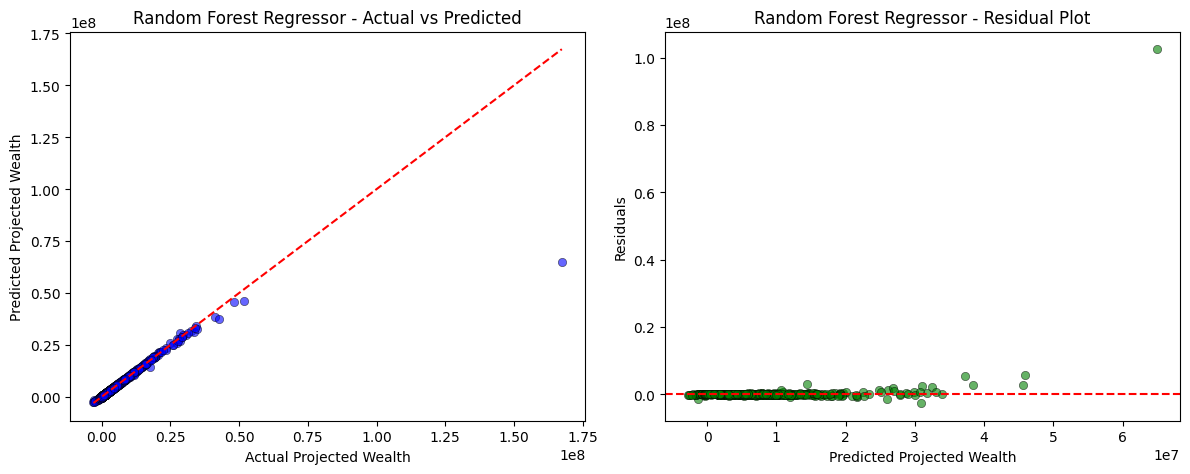

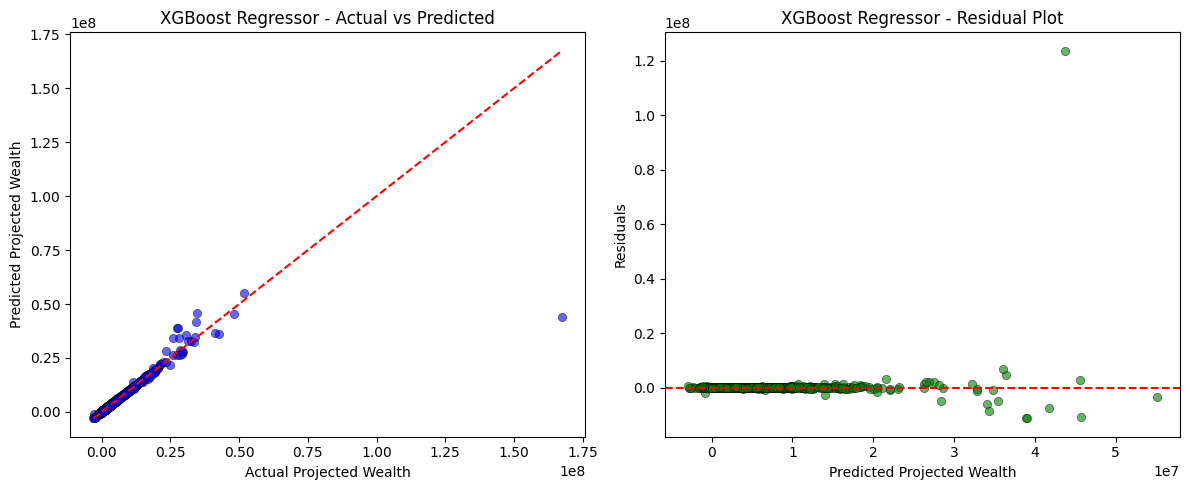

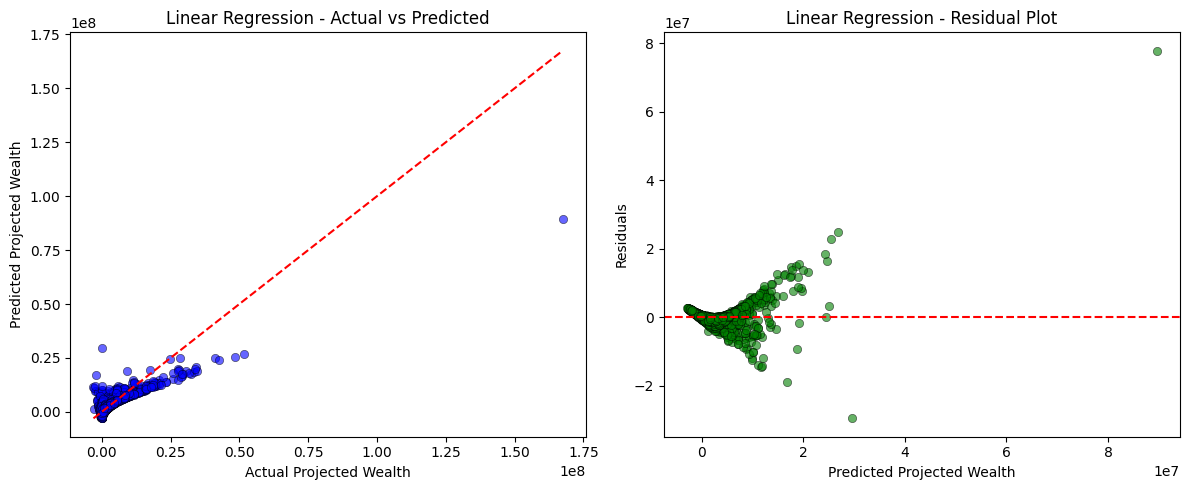

In [266]:
y_pred_rfr = regressors["Random Forest"].predict(X_test)
y_pred_xgb = regressors["XGBoost"].predict(X_test)
y_pred_lr  = regressors["Linear Regression"].predict(X_test)

# Actual target values
y_true = y_test  # assuming y_test is already defined for Projected_Wealth

# Plot for Random Forest Regressor
plot_regression_results(y_true, y_pred_rfr, "Random Forest Regressor")

# Plot for XGBoost Regressor
plot_regression_results(y_true, y_pred_xgb, "XGBoost Regressor")

# Plot for Linear Regression
plot_regression_results(y_true, y_pred_lr, "Linear Regression")


### Random Forest Regressor – Evaluation

#### 1. Actual vs Predicted Plot (Left):
The predicted values are tightly clustered around the ideal red dashed line, suggesting that the Random Forest Regressor delivers highly accurate estimates of projected wealth. Most data points fall very close to the line, indicating excellent model performance with only a few scattered points deviating at higher wealth levels.

#### 2. Residual Plot (Right):
Residuals are distributed randomly around zero, which is a strong indicator of a good fit. The residual spread remains consistently narrow across predicted values, with only a few larger residuals observed on the higher wealth predictions. This implies low bias and variance, showcasing the model’s ability to generalize well without overfitting.

#### Conclusion:
The Random Forest Regressor outperforms the other models in terms of predictive accuracy and consistency, as reflected in its superior R² score of approximately **0.87**. It is well-suited for capturing nonlinear relationships and handling diverse wealth profiles in the dataset.

---

### XGBoost Regressor – Evaluation

#### 1. Actual vs Predicted Plot (Left):
The scatter plot shows the predicted projected wealth against the actual values. The red dashed line represents the ideal case where predictions perfectly match actual outcomes. Most data points lie close to this line, indicating that the XGBoost Regressor is capable of capturing the underlying wealth projection patterns quite well. However, a few outliers, especially on the higher wealth end, suggest minor over- or under-estimations.

#### 2. Residual Plot (Right):
The residuals (i.e., the difference between actual and predicted values) are mostly centered around zero, which is desirable. The spread is relatively tight for the majority of predictions, showing that the model is consistent across most data points. That said, the presence of a few large residuals on the upper end implies that for very high projected wealth cases, the model struggles slightly—possibly due to limited representation of such extreme values in the dataset.

#### Conclusion:
Overall, the XGBoost Regressor performs robustly, with accurate predictions and minimal bias across the typical range of wealth values. The visual results support the strong R² score of approximately **0.81**, confirming its effectiveness in this regression task.

---

### Linear Regression – Evaluation

#### 1. Actual vs Predicted Plot (Left):
The Linear Regression model fails to capture the complexities of projected wealth effectively. While the predicted values align with actual ones at lower levels, the deviation becomes significant as wealth increases. The points tend to systematically drift away from the red dashed line, highlighting the model’s inability to adapt to nonlinear patterns in the data.

#### 2. Residual Plot (Right):
The residuals show a clear pattern and are not randomly scattered around zero. There is a visible cone-shaped distribution, where residual variance increases with predicted wealth. This phenomenon, known as heteroscedasticity, indicates that the model is not capturing variance consistently and violates core assumptions of linear regression.

#### Conclusion:
Linear Regression underperforms in this regression task, particularly at predicting higher wealth values. Its simplicity fails to account for complex interactions between features, resulting in a relatively lower R² score of around **0.74**. This model may only be suitable for basic approximations or when data is known to follow a linear trend.


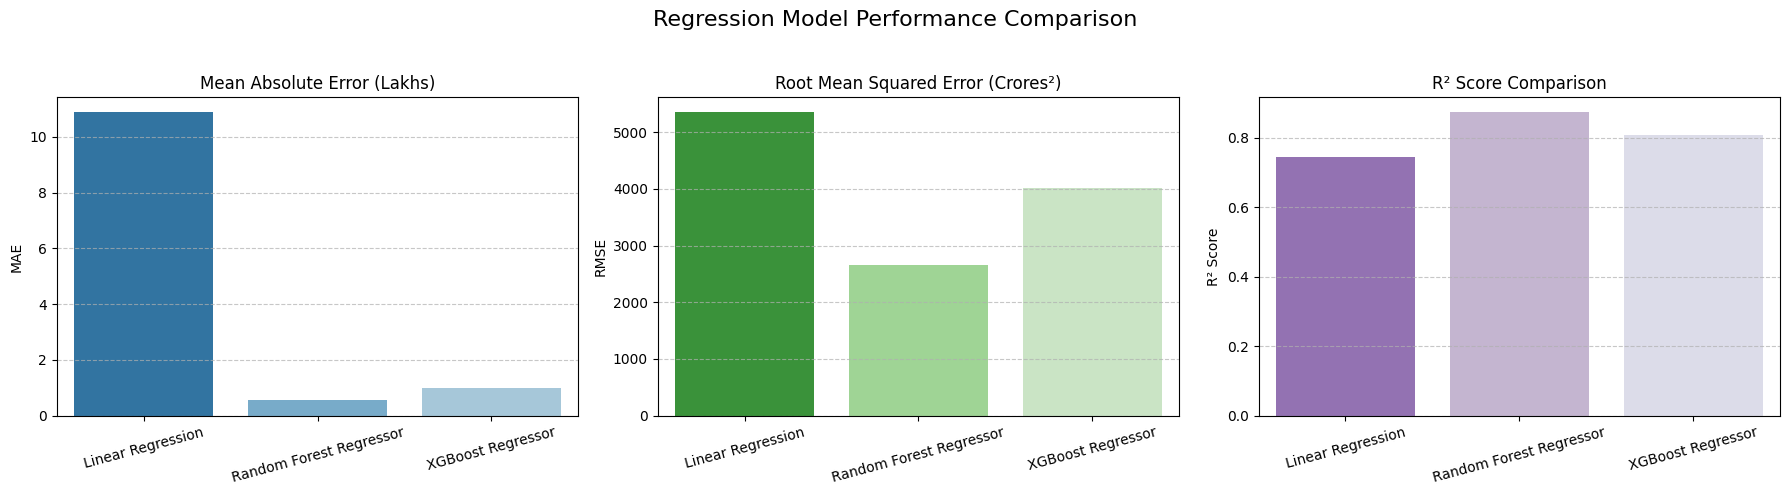

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

# Regressor Models
models = ['Linear Regression', 'Random Forest Regressor', 'XGBoost Regressor']

# Metric Values
mae = [10.87, 0.56, 1.01]        # in Lakhs
rmse = [5345, 2660, 4008]        # in Crores^2
r2 = [0.745, 0.873, 0.809]       # unitless

# Custom colors
colors_mae = ['#1f77b4', '#6baed6', '#9ecae1']
colors_rmse = ['#2ca02c', '#98df8a', '#c7e9c0']
colors_r2 = ['#9467bd', '#c5b0d5', '#dadaeb']

# Create a 1x3 grid for MAE, RMSE, R²
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE Plot
sns.barplot(ax=axes[0], x=models, y=mae, palette=colors_mae)
axes[0].set_title('Mean Absolute Error (Lakhs)', fontsize=12)
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# RMSE Plot
sns.barplot(ax=axes[1], x=models, y=rmse, palette=colors_rmse)
axes[1].set_title('Root Mean Squared Error (Crores²)', fontsize=12)
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# R² Score Plot
sns.barplot(ax=axes[2], x=models, y=r2, palette=colors_r2)
axes[2].set_title('R² Score Comparison', fontsize=12)
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Overall layout
plt.suptitle('Regression Model Performance Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Regression Model Comparison using Performance Metrics

To compare the effectiveness of our regression models — **Linear Regression**, **Random Forest Regressor**, and **XGBoost Regressor** — we evaluate them using the following performance metrics:

1. **Mean Absolute Error (MAE)**  
   This metric measures the average magnitude of errors in predictions, without considering their direction. It is expressed here in **Lakhs** of INR, which is more intuitive for Indian financial contexts. Lower MAE indicates better performance.

2. **Root Mean Squared Error (RMSE)**  
   RMSE is sensitive to large errors, as it squares the difference between predicted and actual values before averaging. It is expressed in **Crores²**. A smaller RMSE means better predictive power.

3. **R² Score (Coefficient of Determination)**  
   R² explains the proportion of variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, with 1 meaning perfect prediction.

The following bar plots visualize these metrics for all three models using color-coded palettes for better distinction:
- **Blues** for MAE
- **Greens** for RMSE
- **Purples** for R² Score

These visualizations help in quickly identifying which model performs best across different error measures.


## Conclusion and Future Work

This study explored the application of machine learning models to predict long-term wealth accumulation for Indian households based on their income, expenditure behavior, and financial discipline. The project aimed to answer two core questions:  
1. **Classification** – Will an individual be wealthy by the age of 60?  
2. **Regression** – What will be the individual’s projected wealth at 60?

### Key Findings

1. **Feature Engineering & Behavioral Insights**:  
   Rather than relying solely on income, derived features such as `Monthly_Savings`, `Savings_Rate`, and `Projected_Wealth` offered deeper insights into financial health. This emphasized that **consistent saving behavior has more predictive power than high income alone**.

2. **Classification Results**:  
   Among all models tested, **Random Forest Classifier** and **XGBoost Classifier** outperformed others with near-perfect accuracy (~99.6%), precision, and recall. These ensemble methods successfully captured non-linear patterns and interactions in the data, making them especially well-suited for structured tabular datasets.  
   The **Logistic Regression** model, although simpler, performed reasonably well (96.3% accuracy), while **MLP Classifier** also achieved high accuracy, indicating potential for neural networks on structured finance data.

3. **Regression Results**:  
   The **Random Forest Regressor** emerged as the most accurate model for predicting projected wealth, achieving an **R² score of 0.87**, significantly outperforming both Linear Regression (R² = 0.74) and XGBoost (R² = 0.81).  
   Linear Regression struggled due to the complex, non-linear nature of the wealth accumulation process.

4. **Model Interpretability**:  
   Feature importance analysis confirmed that **Monthly Savings**, **Savings Rate**, and **Age** were the most influential factors for wealth prediction. While income contributes, **financial discipline and saving behavior are the true drivers of long-term financial success**.

---

### Limitations

- The wealth projection did **not consider interest rates or compounding**, which may lead to underestimation.
- Real-world financial scenarios such as inflation, market returns, emergencies, or career breaks were not modeled.
- The dataset was assumed clean and consistent after preprocessing, which may not reflect real-world financial irregularities.

---

### Future Work

1. **Include Compounding and Investment Returns**:  
   Enhancing the `Projected_Wealth` formula using real-world investment models (e.g., SIPs, mutual funds, fixed deposits) with inflation adjustment can make predictions more realistic.

2. **Behavioral Segmentation**:  
   Clustering users based on saving/spending behavior could allow for **personalized financial recommendations** and benchmarking.

3. **Explainable AI (XAI)**:  
   Incorporating **SHAP or LIME** explainability techniques could provide actionable insights to users and policymakers.

4. **Web App Integration**:  
   Deploying the trained model in a user-friendly web or mobile application can **help users forecast their financial future interactively**, turning this academic project into a real-world fintech tool.

---

### Final Thought

This project demonstrates that **machine learning is not just a tool for prediction**, but also a **lens to understand personal financial behavior**. With responsible application and user-focused design, such tools can empower individuals to take control of their financial future.
